# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [17]:
%run "../config/notebook_settings.py"

from helpers.utilities import Timer, get_logger
from helpers.text_processing import count_tokens, tf_idf

def get_project_directory():
    return os.getcwd().replace('/source/executables', '')

print(get_project_directory())

/Users/shanekercheval/repos/nlp-template


In [2]:
with Timer("Loading Data"):
    path = os.path.join(get_project_directory(), 'artifacts/data/processed/un-general-debates-blueprint.pkl')
    df = pd.read_pickle(path)

Started: Loading Data
Finished (0.80 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

In [3]:
hlp.pandas.numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
session,"7,507",0,0.0%,0,0.0%,49.6,12.9,0.3,-0.2,-1.1,25,31.0,39.0,51.0,61.0,67.0,70
year,"7,507",0,0.0%,0,0.0%,"1,994.6",12.9,0.0,-0.2,-1.1,"1,970","1,976.0","1,984.0","1,996.0","2,006.0","2,012.0","2,015"
num_tokens,"7,507",0,0.0%,0,0.0%,"1,480.3",635.2,0.4,1.1,1.7,187,793.6,"1,005.5","1,358.0","1,848.0","2,336.4","5,688"
text_length,"7,507",0,0.0%,0,0.0%,"17,967.3","7,860.0",0.4,1.1,1.8,"2,362","9,553.8","12,077.0","16,424.0","22,479.5","28,658.2","72,041"


In [4]:
hlp.pandas.non_numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"7,507",0,0.0%,ALB,199,2.7%
country_name,"7,507",0,0.0%,Albania,199,2.7%
speaker,"7,507",0,0.0%,<unknown>,"5,429",72.3%
position,"7,507",0,0.0%,<unknown>,114,1.5%
text,"7,507",0,0.0%,33: May I first convey to our [...],"7,507",100.0%
tokens,"7,507",0,0.0%,"['may', 'first', 'convey', 'pr[...]","7,507",100.0%


---

## Explore Non-Text Columns

Explore idiosyncrasies of various columns, e.g. same speaker represented multiple ways.

In [5]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

---

## Explore Text Column|

### Top Words Used

In [6]:
count_tokens(df['tokens']).head(20)

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


---

### Distribution of Text Length

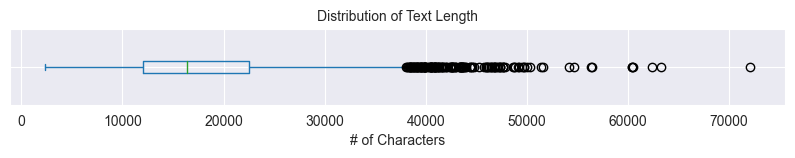

In [7]:
ax = df['text_length'].plot(kind='box', vert=False, figsize=(10, 1))
ax.set_title("Distribution of Text Length")
ax.set_xlabel("# of Characters")
ax.set_yticklabels([])
ax;

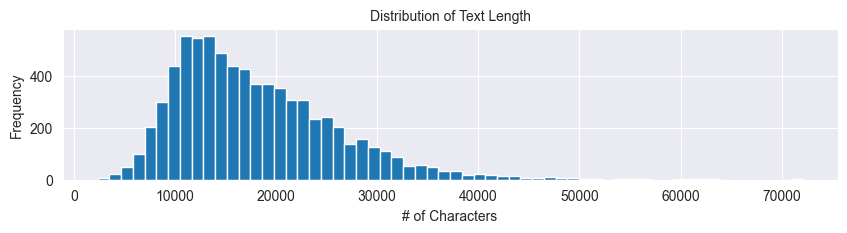

In [8]:
ax = df['text_length'].plot(kind='hist', bins=60, figsize=(10, 2));
ax.set_title("Distribution of Text Length")
ax.set_xlabel("# of Characters")
ax;

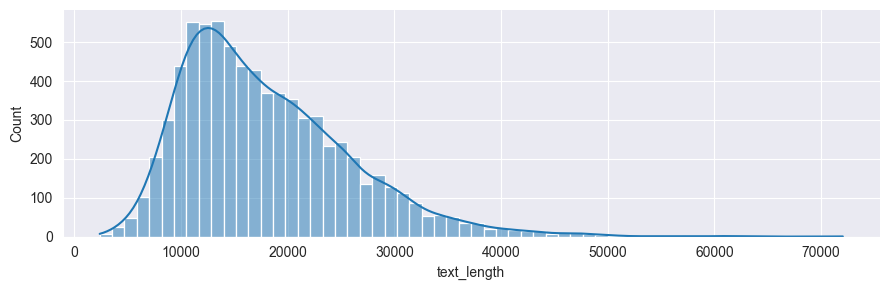

In [9]:
import seaborn as sns
sns.displot(df['text_length'], bins=60, kde=True, height=3, aspect=3);

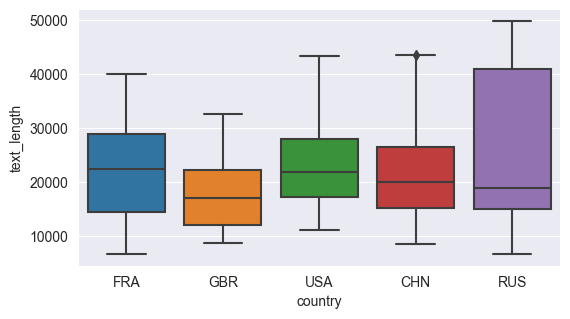

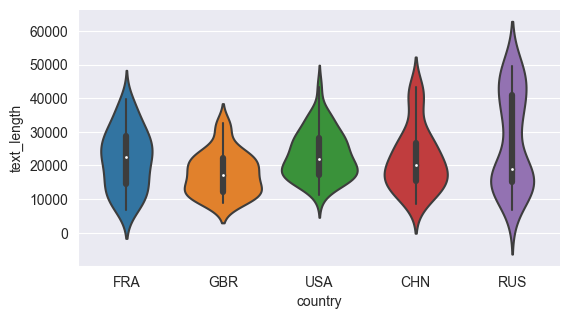

In [10]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="text_length", kind='box')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="country", y="text_length", kind='violin')
g.fig.set_size_inches(6, 3)
g.fig.set_dpi(100)

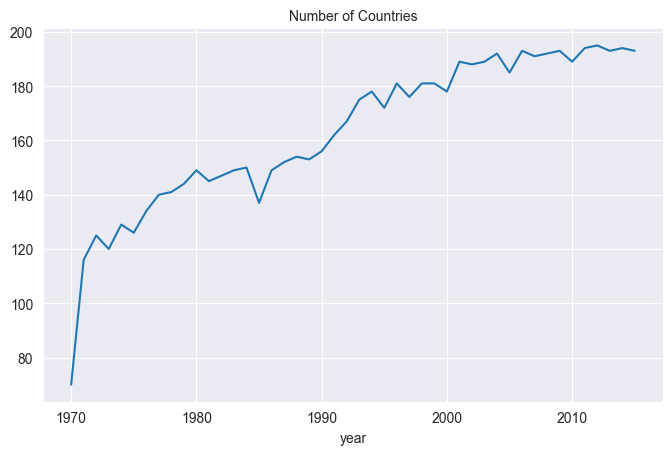

In [11]:
assert not df[['year', 'country']].duplicated().any()
df.groupby('year').size().plot(title="Number of Countries");

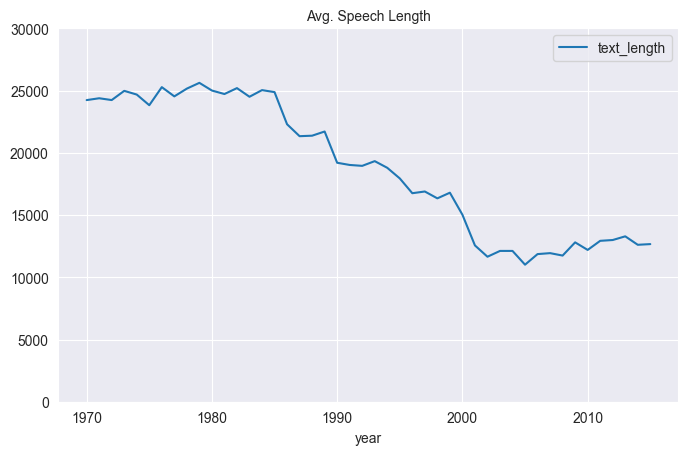

In [12]:
df.groupby('year').agg({'text_length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000));

### Word Frequency

In [13]:
counts_df = count_tokens(df['tokens'])

In [81]:
counts_df.head()

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [66]:
def plot_wordcloud(frequency_dict):
    wc = wordcloud.WordCloud(background_color='white',
        #colormap='RdYlGn',
        colormap='tab20b',
        width=round(hlp.plot.STANDARD_WIDTH*100),
        height=round(hlp.plot.STANDARD_HEIGHT*100),
        max_words = 200, max_font_size=150,
        random_state=42
    )
    wc.generate_from_frequencies(frequency_dict)

    fig, ax = plt.subplots(figsize=(hlp.plot.STANDARD_WIDTH, hlp.plot.STANDARD_HEIGHT))
    ax.imshow(wc, interpolation='bilinear')
    #plt.title("XXX")
    plt.axis('off')

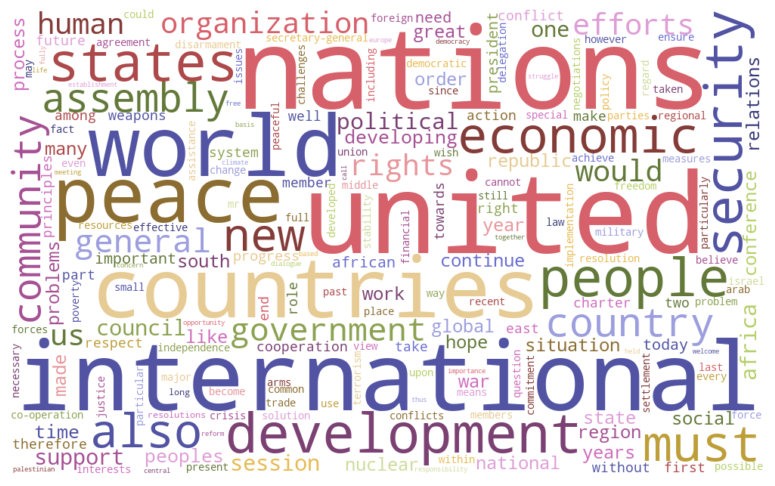

In [67]:
plot_wordcloud(counts_df.to_dict()['frequency']);

### TF-IDF

In [68]:
tf_idf_df = tf_idf(
    df=df,
    tokens_column='tokens',
    segment_columns = None,
    min_frequency_corpus=20,
    min_frequency_document=20,
)

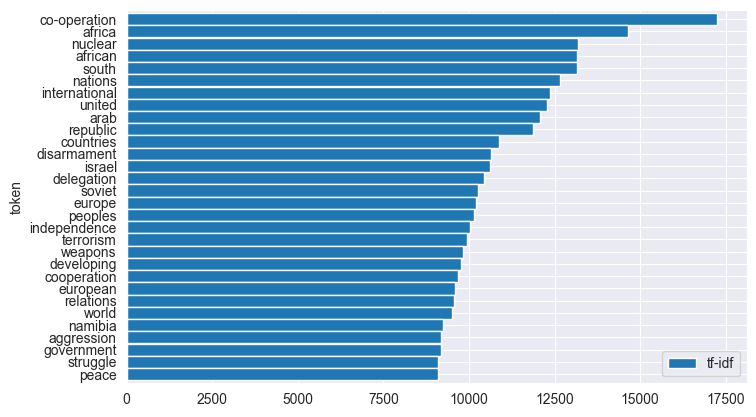

In [94]:
ax = tf_idf_df.head(30)[['tf-idf']].plot(kind='barh', width=0.99)
ax.invert_yaxis();

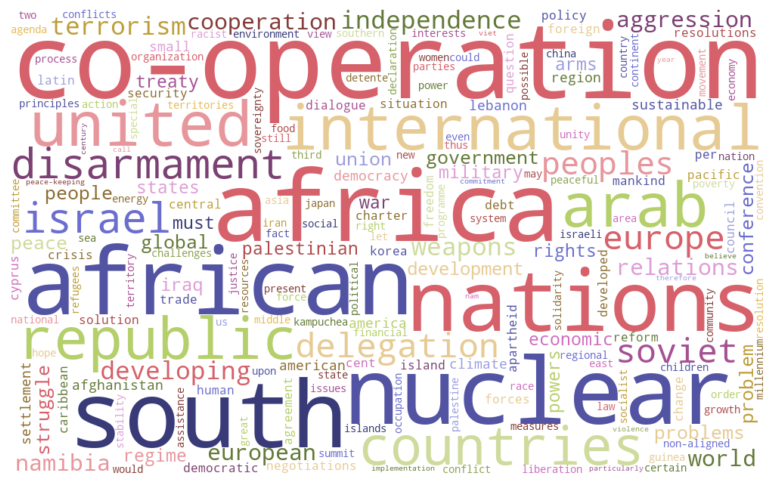

In [69]:
plot_wordcloud(tf_idf_df.to_dict()['tf-idf']);

In [76]:
tf_idf_per_year = tf_idf(
    df=df,
    tokens_column='tokens',
    segment_columns = 'year',
    min_frequency_corpus=10,
    min_frequency_document=10,
)

In [77]:
stop_words = ['twenty-fifth', 'twenty-five', 'twenty', 'fifth']
tokens_to_show = tf_idf_per_year.query('year == 1970').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
print(tokens_to_show.head())
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']

   year             token  frequency  tf-idf
0  1970           vietnam        119  516.63
3  1970            seabed         90  355.36
4  1970              arab        293  341.33
5  1970            decade        241  307.72
6  1970  secretarygeneral         72  297.59


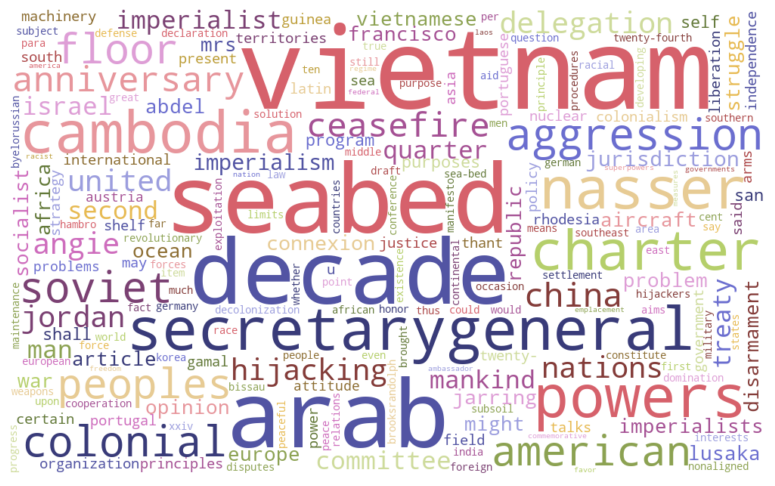

In [78]:
plot_wordcloud(tokens_to_show);

In [79]:
stop_words = ['seventieth']
tokens_to_show = tf_idf_per_year.query('year == 2015').reset_index()
tokens_to_show = tokens_to_show[~tokens_to_show.token.isin(stop_words)]
print(tokens_to_show.head())
tokens_to_show = tokens_to_show[['token', 'tf-idf']].set_index('token')
tokens_to_show = tokens_to_show.to_dict()['tf-idf']

   year        token  frequency  tf-idf
0  2015           pv        468 1195.43
2  2015  sustainable        739  791.97
3  2015        syria        278  638.00
4  2015      climate        662  597.79
5  2015    humankind        281  532.75


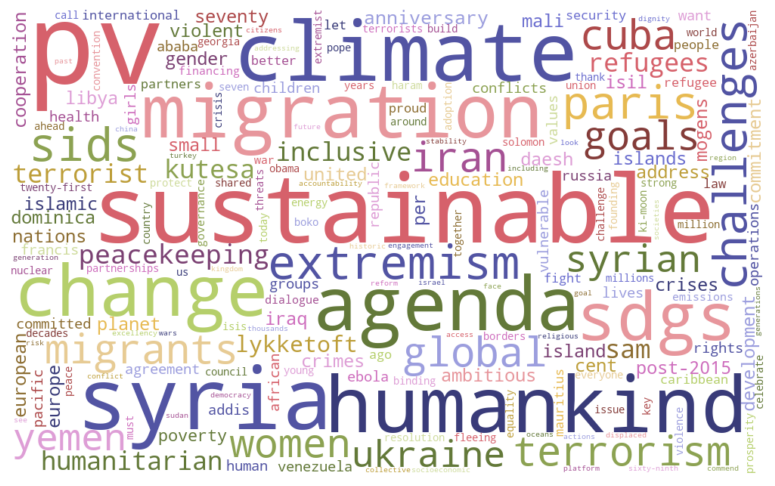

In [80]:
plot_wordcloud(tokens_to_show);